In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ✅ Define `load_png_slice` function before using it
def load_png_slice(file_path, target_shape=(128, 128)):
    """Load a PNG image as a grayscale slice, resize, and normalize it."""
    try:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if img is None:
            raise ValueError(f"Failed to load image: {file_path}")
        
        img = cv2.resize(img, target_shape, interpolation=cv2.INTER_LINEAR)  # Resize
        img = img.astype(np.float32) / 255.0  # Normalize to [0,1]

        return img
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

def get_all_slices(dataset_root):
    """
    Retrieve PNG slices for MCI and NC subjects from Sliced_X_RD, Sliced_Y_RD, and Sliced_Z_RD folders.
    """
    all_slices = []
    all_labels = []
    missing_subjects = []

    categories = ["MCI", "NC"]

    for category in categories:
        category_path = os.path.join(dataset_root, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: Category folder '{category_path}' not found.")
            continue

        for subject in os.listdir(category_path):
            subject_path = os.path.join(category_path, subject)
            if not os.path.isdir(subject_path):
                continue

            # Define paths for required slice folders
            axis_paths = {
                "X": os.path.join(subject_path, "Sliced_X_RD"),
                "Y": os.path.join(subject_path, "Sliced_Y_RD"),
                "Z": os.path.join(subject_path, "Sliced_Z_RD"),
            }

            # Check if all required slice folders exist
            if not all(os.path.exists(path) for path in axis_paths.values()):
                missing_subjects.append(subject)
                continue

            # Collect and sort slice files
            slice_files = {axis: sorted(
                [f for f in os.listdir(axis_paths[axis]) if f.endswith(".png")],
                key=lambda x: int(''.join(filter(str.isdigit, x)))  # Sort numerically
            ) for axis in ["X", "Y", "Z"]}

            # Ensure each axis has slices
            min_slices = min(len(slice_files["X"]), len(slice_files["Y"]), len(slice_files["Z"]))
            if min_slices == 0:
                missing_subjects.append(subject)
                continue

            for i in range(min_slices):
                slice_paths = {
                    "X": os.path.join(axis_paths["X"], slice_files["X"][i]),
                    "Y": os.path.join(axis_paths["Y"], slice_files["Y"][i]),
                    "Z": os.path.join(axis_paths["Z"], slice_files["Z"][i])
                }

                # ✅ Now `load_png_slice` is defined, so this won't cause an error
                slices = [load_png_slice(slice_paths[axis]) for axis in ["X", "Y", "Z"]]

                if any(s is None for s in slices):
                    continue

                combined_slices = np.stack(slices, axis=-1)
                all_slices.append(combined_slices)
                all_labels.append(1 if category == "MCI" else 0)

    if missing_subjects:
        print(f"⚠️ Subjects with missing slices: {len(missing_subjects)}")

    print(f"✅ Total Slices Loaded: {len(all_slices)}")

    return np.array(all_slices, dtype=np.float32), np.array(all_labels, dtype=np.int32)

# 📌 Load Data
dataset_root = r"C:\Users\OMEN\Desktop\Almaz Project\sliced_data\sliced_data"
data, labels = get_all_slices(dataset_root)

if data.shape[0] == 0:
    print("❌ No valid slices loaded. Please check your dataset paths!")
else:
    print(f"✅ Loaded {len(labels)} samples with shape {data.shape}")  # Shape should be (N, 128, 128, 3)
    print(f"✅ Labels Shape: {labels.shape}")


✅ Total Slices Loaded: 20200
✅ Loaded 20200 samples with shape (20200, 128, 128, 3)
✅ Labels Shape: (20200,)


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 🔹 Ensure GPU is disabled (Even if CUDA is Installed)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.set_visible_devices([], 'GPU')

print("✅ Running on CPU only:", tf.config.list_physical_devices('GPU'))

# 📌 Assume 'data' and 'labels' are numpy arrays
# data.shape => (num_samples, 128, 128, 3)
# labels.shape => (num_samples, )

# 🔹 Define a 2D CNN Model for MCI vs NC Classification (With 3-Channel Input)
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary Classification (MCI vs NC)
    ])
    return model

# 🔹 K-Fold Cross Validation Settings
K = 5
EPOCHS = 20
BATCH_SIZE = 16

# StratifiedKFold ensures each fold has the same class distribution
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Collect fold metrics
fold_accuracies = []
fold_losses = []

# 🔹 K-Fold Loop
for fold, (train_index, val_index) in enumerate(kf.split(data, labels), 1):
    print(f"\n🔹 Fold {fold}/{K} 🔹")
    
    # Split data
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    # Dataset optimizations
    train_dataset = (train_dataset
                     .shuffle(len(X_train))
                     .batch(BATCH_SIZE)
                     .cache()
                     .prefetch(tf.data.AUTOTUNE))

    val_dataset = (val_dataset
                   .batch(BATCH_SIZE)
                   .cache()
                   .prefetch(tf.data.AUTOTUNE))

    # Build and compile a fresh model for each fold
    model = build_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    print(f"✅ Fold {fold} - Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4%}")

    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)

# 🔹 Average Metrics Across Folds
print("\n🔹 Cross Validation Results 🔹")
print(f"✅ Average Validation Accuracy: {np.mean(fold_accuracies):.4%} (+/- {np.std(fold_accuracies):.4%})")
print(f"✅ Average Validation Loss: {np.mean(fold_losses):.4f} (+/- {np.std(fold_losses):.4f})")



✅ Running on CPU only: []

🔹 Fold 1/5 🔹


Epoch 1/20


1010/1010 [==============================] - 166s 163ms/step - loss: 0.8692 - accuracy: 0.5291 - val_loss: 0.7687 - val_accuracy: 0.5309 - lr: 1.0000e-04
Epoch 2/20
1010/1010 [==============================] - 158s 156ms/step - loss: 0.7723 - accuracy: 0.5475 - val_loss: 0.7458 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 3/20
1010/1010 [==============================] - 157s 156ms/step - loss: 0.7571 - accuracy: 0.5699 - val_loss: 0.7329 - val_accuracy: 0.6025 - lr: 1.0000e-04
Epoch 4/20
1010/1010 [==============================] - 161s 159ms/step - loss: 0.7293 - accuracy: 0.5985 - val_loss: 0.6934 - val_accuracy: 0.6379 - lr: 1.0000e-04
Epoch 5/20
1010/1010 [==============================] - 152s 150ms/step - loss: 0.6874 - accuracy: 0.6366 - val_loss: 0.6623 - val_accuracy: 0.6502 - lr: 1.0000e-04
Epoch 6/20
1010/1010 [==============================] - 151s 150ms/step - loss: 0.6211 - accuracy: 0.6842 - val_loss: 0.6249 - val_

1010/1010 [==============================] - 50s 49ms/step


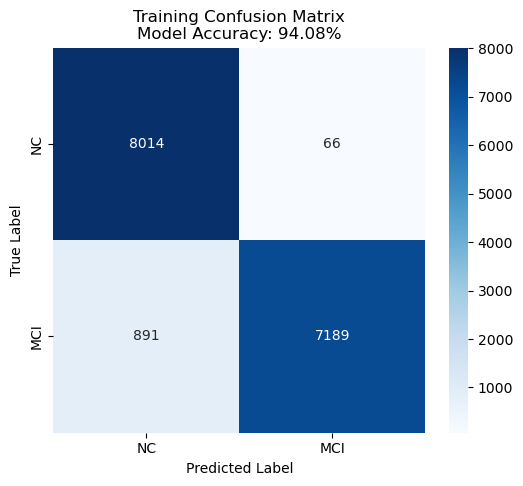

✅ Training Model Accuracy (from Confusion Matrix): 94.08%
✅ Training Model Accuracy (from Evaluation): 94.08%

Training Classification Report:
               precision    recall  f1-score   support

          NC       0.90      0.99      0.94      8080
         MCI       0.99      0.89      0.94      8080

    accuracy                           0.94     16160
   macro avg       0.95      0.94      0.94     16160
weighted avg       0.95      0.94      0.94     16160



In [5]:
#confusion matrix for training dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Get Model Predictions for Training Data
y_train_pred_prob = model.predict(train_dataset)  # Get predicted probabilities
y_train_pred = (y_train_pred_prob > 0.5).astype("int32")  # Convert to binary (0 or 1)

# ✅ Convert True Labels to Numpy Array
y_train_true = np.concatenate([y for _, y in train_dataset], axis=0)  # Extract true labels

# ✅ Compute Confusion Matrix for Training Data
cm_train = confusion_matrix(y_train_true, y_train_pred)

# ✅ Compute Accuracy from Confusion Matrix
accuracy_cm_train = np.trace(cm_train) / np.sum(cm_train)  # (TP + TN) / Total Samples

# ✅ Compute Accuracy from Model Evaluation on Training Data
loss_train, accuracy_eval_train = model.evaluate(train_dataset, verbose=0)

# ✅ Plot Training Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['NC', 'MCI'], yticklabels=['NC', 'MCI'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Training Confusion Matrix\nModel Accuracy: {accuracy_eval_train:.2%}")
plt.show()

# ✅ Print Accuracy & Classification Report for Training Data
print(f"✅ Training Model Accuracy (from Confusion Matrix): {accuracy_cm_train:.2%}")
print(f"✅ Training Model Accuracy (from Evaluation): {accuracy_eval_train:.2%}")
print("\nTraining Classification Report:\n", classification_report(y_train_true, y_train_pred, target_names=['NC', 'MCI']))


253/253 [==============================] - 13s 50ms/step


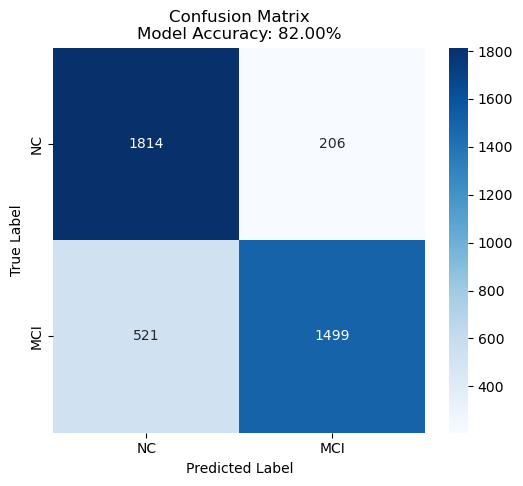

✅ Model Accuracy (from Confusion Matrix): 82.00%
✅ Model Accuracy (from Evaluation): 82.00%

Classification Report:
               precision    recall  f1-score   support

          NC       0.78      0.90      0.83      2020
         MCI       0.88      0.74      0.80      2020

    accuracy                           0.82      4040
   macro avg       0.83      0.82      0.82      4040
weighted avg       0.83      0.82      0.82      4040



In [9]:
#confusion matrix for testing dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Get Model Predictions
y_pred_prob = model.predict(val_dataset)  # Get predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert to binary (0 or 1)

# ✅ Convert True Labels to Numpy Array
y_true = np.concatenate([y for _, y in val_dataset], axis=0)  # Extract true labels

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Compute Accuracy from Confusion Matrix
accuracy_cm = np.trace(cm) / np.sum(cm)  # (TP + TN) / Total Samples

# ✅ Compute Accuracy from Model Evaluation
loss, accuracy_eval = model.evaluate(val_dataset, verbose=0)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NC', 'MCI'], yticklabels=['NC', 'MCI'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix\nModel Accuracy: {accuracy_eval:.2%}")
plt.show()

# ✅ Print Accuracy & Classification Report
print(f"✅ Model Accuracy (from Confusion Matrix): {accuracy_cm:.2%}")
print(f"✅ Model Accuracy (from Evaluation): {accuracy_eval:.2%}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['NC', 'MCI']))

In [ ]:
import tensorflow

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates